# Forecasting tests

In [10]:
#@title Install packages and get data
!pip install sktime >/dev/null
!pip install pmdarima >/dev/null
!wget 'https://docs.google.com/uc?export=download&id=1BsGqndPLRe0XGeOwH3-W09LE2h4FKDiE' -O data.xlsx >/dev/null

--2021-03-20 13:14:25--  https://docs.google.com/uc?export=download&id=1BsGqndPLRe0XGeOwH3-W09LE2h4FKDiE
Resolving docs.google.com (docs.google.com)... 74.125.129.139, 74.125.129.100, 74.125.129.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.129.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-5s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k5fc8lg5bop96slu1keol5aatdt8vskd/1616246025000/09666267334096540847/*/1BsGqndPLRe0XGeOwH3-W09LE2h4FKDiE?e=download [following]
--2021-03-20 13:14:26--  https://doc-00-5s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k5fc8lg5bop96slu1keol5aatdt8vskd/1616246025000/09666267334096540847/*/1BsGqndPLRe0XGeOwH3-W09LE2h4FKDiE?e=download
Resolving doc-00-5s-docs.googleusercontent.com (doc-00-5s-docs.googleusercontent.com)... 172.253.119.132, 2607:f8b0:4001:c23::84
Connecting to doc-00-5s-docs.googleusercontent.com (doc-00-5s-

In [11]:
#@title Import packages

from warnings import simplefilter

from datetime import datetime, date
import time
from tqdm.notebook import tqdm
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
# from sktime.utils.plotting import plot_series

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer

tqdm.pandas() # progress_apply
simplefilter("ignore", FutureWarning)
%matplotlib inline

In [12]:
#@title Functions from sk-time github

# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import time
from sktime.utils.validation.forecasting import check_y
from sktime.utils.validation.forecasting import check_cv
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.validation.forecasting import check_scoring
from sklearn.base import clone

__author__ = ["Martin Walter"]
__all__ = ["evaluate"]


def evaluate(
    forecaster, cv, y, X=None, strategy="refit", scoring=None, return_data=False
):
    """Evaluate forecaster using cross-validation
    Parameters
    ----------
    forecaster : sktime.forecaster
        Any forecaster
    cv : sktime.SlidingWindowSplitter or sktime.ExpandingWindowSplitter
        Splitter of how to split the data into test data and train data
    y : pd.Series
        Target time series to which to fit the forecaster.
    X : pd.DataFrame, optional (default=None)
        Exogenous variables
    strategy : str, optional
        Must be "refit" or "update", by default "refit". The strategy defines
        whether forecaster is only fitted on the first train window data and
        then updated or always refitted.
    scoring : object of class MetricFunctionWrapper from
        sktime.performance_metrics, optional. Example scoring=sMAPE().
        Used to get a score function that takes y_pred and y_test as arguments,
        by default None (if None, uses sMAPE)
    return_data : bool, optional
        Returns three additional columns in the DataFrame, by default False.
        The cells of the columns contain each a pd.Series for y_train,
        y_pred, y_test.
    Returns
    -------
    pd.DataFrame
        DataFrame that contains several columns with information regarding each
        refit/update and prediction of the forecaster.
    Examples
    --------
    >>> from sktime.datasets import load_airline
    >>> from sktime.performance_metrics.forecasting import evaluate
    >>> from sktime.forecasting.model_selection import ExpandingWindowSplitter
    >>> from sktime.forecasting.naive import NaiveForecaster
    >>> y = load_airline()
    >>> forecaster = NaiveForecaster(strategy="drift", sp=12)
    >>> cv = ExpandingWindowSplitter(
        initial_window=24,
        step_length=12,
        fh=[1,2,3,4,5,6,7,8,9,10,11,12]
        )
    >>> evaluate(forecaster=forecaster, y=y, cv=cv)
    """
    cv = check_cv(cv)
    y = check_y(y)
    _check_strategies(strategy)
    scoring = check_scoring(scoring)

    results = pd.DataFrame()
    cv.start_with_window = True

    for i, (train, test) in tqdm(enumerate(cv.split(y))):
        # get initial window, if required
        if i == 0 and cv.initial_window and strategy == "update":
            train, test = cv.split_initial(y)
            # this might have to be directly handled in split_initial()
            test = test[: len(cv.fh)]

        # create train/test data
        y_train = y.iloc[train]
        y_test = y.iloc[test]

        X_train = X.iloc[train] if X is not None else None
        X_test = X.iloc[test] if X is not None else None
        
        # fit/update
        inner_forecaster = clone(forecaster)

        start_fit = time.time()
        if strategy == "refit" or i == 0:
            inner_forecaster.fit(
                y=y_train,
                X=X_train,
                fh=ForecastingHorizon(y_test.index, is_relative=False),
            )
        else:
            # strategy == "update" and i != 0:
            inner_forecaster.update(y=y_train, X=X_train)
        fit_time = time.time() - start_fit

        # predict
        start_pred = time.time()
        y_pred = inner_forecaster.predict(
            fh=ForecastingHorizon(y_test.index, is_relative=False), # X=X_test
        )
        pred_time = time.time() - start_pred
        
        # save results
        results = results.append(
            {
                "test_" + scoring.__class__.__name__: scoring(y_pred, y_test),
                "test_RMSE": mean_squared_error(y_pred, y_test, squared=False),
                "fit_time": fit_time,
                "pred_time": pred_time,
                "len_train_window": len(y_train),
                "cutoff": inner_forecaster.cutoff,
                "y_train": y_train if return_data else np.nan,
                "y_test": y_test if return_data else np.nan,
                "y_pred": y_pred if return_data else np.nan,
            },
            ignore_index=True,
        )

    # post-processing of results
    if not return_data:
        results = results.drop(columns=["y_train", "y_test", "y_pred"])
    results["len_train_window"] = results["len_train_window"].astype(int)

    return results


def _check_strategies(strategy):
    """Assert strategy value
    Parameters
    ----------
    strategy : str
        strategy of how to evaluate a forecaster
    Raises
    ------
    ValueError
        If strategy value is not in expected values, raise error.
    """
    if strategy not in ["refit", "update"]:
        raise ValueError('strategy must be either "refit" or "update"')


#!/usr/bin/env python3 -u
# -*- coding: utf-8 -*-
# copyright: sktime developers, BSD-3-Clause License (see LICENSE file)

__all__ = ["plot_series"]
__author__ = ["Markus Löning"]

import numpy as np

from sktime.utils.validation._dependencies import _check_soft_dependencies
from sktime.utils.validation.forecasting import check_y


def plot_series(*series, labels=None, markers=None):
    """Plot one or more time series
    Parameters
    ----------
    series : pd.Series
        One or more time series
    labels : list, optional (default=None)
        Names of series, will be displayed in figure legend
    markers: list, optional (default=None)
        Markers of data points, if None the marker "o" is used by default.
        Lenght of list has to match with number of series
    Returns
    -------
    fig : plt.Figure
    ax : plt.Axis
    """
    _check_soft_dependencies("matplotlib", "seaborn")
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter, MaxNLocator
    from matplotlib.cbook import flatten
    import seaborn as sns

    for y in series:
        check_y(y)

    n_series = len(series)

    # labels
    if labels is not None:
        if n_series != len(labels):
            raise ValueError(
                """There must be one label for each time series,
                but found inconsistent numbers of series and
                labels."""
            )
        legend = True
    else:
        labels = ["" for _ in range(n_series)]
        legend = False

    # markers
    if markers is not None:
        if n_series != len(markers):
            raise ValueError(
                """There must be one marker for each time series,
                but found inconsistent numbers of series and
                markers."""
            )
    else:
        markers = ["o" for _ in range(n_series)]

    # create combined index
    index = series[0].index
    for y in series[1:]:
        # check types, note that isinstance() does not work here because index
        # types inherit from each other, hence we check for type equality
        if not type(index) is type(y.index):  # noqa
            raise TypeError("Found series with different index types.")
        index = index.union(y.index)

    # generate integer x-values
    xs = [np.argwhere(index.isin(y.index)).ravel() for y in series]

    # create figure
    fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
    colors = sns.color_palette("colorblind", n_colors=n_series)

    # plot series
    for x, y, color, label, marker in zip(xs, series, colors, labels, markers):

        # scatter if little data is available or index is not complete
        if len(x) <= 3 or not np.array_equal(np.arange(x[0], x[-1] + 1), x):
            plot_func = sns.scatterplot
        else:
            plot_func = sns.lineplot

        plot_func(x=x, y=y, ax=ax, marker=marker, label=label, color=color)

    # combine data points for all series
    xs_flat = list(flatten(xs))

    # set x label of data point to the matching index
    def format_fn(tick_val, tick_pos):
        if int(tick_val) in xs_flat:
            return index[int(tick_val)]
        else:
            return ""

    # dynamically set x label ticks and spacing from index labels
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if legend:
        ax.legend()

    return fig, ax

In [13]:
#@title Recursive forecaster
# My class for recursive forecasting. Does not support X when predicting
class MyReducedRecursiveForecaster(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator,
        strategy='recursive',
        window_length=10,
        step_length=1
    ):

        self.estimator = estimator
        self.strategy = strategy
        self.window_length = window_length
        self.step_length = step_length
        self.has_X = False
        if self.strategy == 'recursive':
            self._cv = SlidingWindowSplitter(
            fh=1,
            window_length=self.window_length,
            step_length=self.step_length,
            start_with_window=True,
            )
      
    def fit(self, y, X = None):

        # Save last index
        self.cutoff = y.index[-1]

        # If has X
        if X is not None:
            self.has_X = True

        # Create table of data to pass into an estimator
        x_windows = []
        y_windows = []
        # Use sliding window
        for x_index, y_index in self._cv.split(y):
            if self.has_X:
                x_window = pd.concat([X.iloc[x_index], y.iloc[x_index]], axis=1).values.flatten()
            else:
                x_window = y.iloc[x_index]
            y_window = y.iloc[y_index]

            x_windows.append(x_window)
            y_windows.append(y_window)
        
        X_train_tab = np.vstack(x_windows)
        y_train_tab = np.array(y_windows)
        
        # estimator = clone(self.estimator)
        self.estimator.fit(X_train_tab, y_train_tab)
        # self.estimator_ = estimator

        # Save last window
        self.last_window = y.iloc[-self.window_length:]
        if self.has_X:
            self.last_window_X = X.iloc[-self.window_length:]
        else:
            self.last_window_X = None

        self._is_fitted = True
        return self
    
    def predict(self, fh, y = None, X = None):

        if self.has_X:
            if X is None:
                raise ValueError(
                    'You need to provide X!'
                )

        # Number of steps to predict
        if isinstance(fh, ForecastingHorizon):
            steps_ahead = (fh[-1] - self.cutoff).n
            fh = fh.to_indexer(self.cutoff)
        else:
            steps_ahead = fh[-1]
            fh = np.array(fh) - 1
        
        # Set pred to 0
        y_pred = np.zeros(steps_ahead)

        # Make prediction recursively based on the last window
        last_window = pd.concat([self.last_window_X, self.last_window], axis=1).values.flatten()

        for i in range(steps_ahead):
            y_pred[i] = self.estimator.predict(last_window.reshape(1, -1))
            last_window = np.append(last_window, y_pred[i])[-self.window_length:]
        
        y_pred = pd.Series(
            y_pred, 
            index = pd.PeriodIndex(pd.date_range((self.cutoff + 1).strftime('%Y-%m'), periods=steps_ahead, freq="M"))
            )

        return y_pred[fh]

In [14]:
#@title Direct forecaster
class MyDirectReducerForecaster(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator,
        strategy='direct',
        window_length=10,
        step_length=1
    ):

        self.estimator = estimator
        self.strategy = strategy
        self.window_length = window_length
        self.step_length = step_length
        self.has_X = False
        if self.strategy == 'direct':
            self._cv = SlidingWindowSplitter(
            fh=1,
            window_length=self.window_length,
            step_length=self.step_length,
            start_with_window=True,
            )

    def fit(self, y, X=None, fh=None):
        """Fit to training data.
        Parameters
        ----------
        y : pd.Series
            Target time series to which to fit the forecaster.
        fh : int, list or np.array, optional (default=None)
            The forecasters horizon with the steps ahead to to predict.
        X : pd.DataFrame, optional (default=None)
            Exogenous variables are ignored
        Returns
        -------
        self : returns an instance of self.
        """

        if not fh:
            raise ValueError(
                'You need to provide forecasting horizon'
            )
        self.fh = fh

        # Save last index
        self.cutoff = y.index[-1]

        # fh for sliding window
        self._cv.fh = fh.to_indexer(self.cutoff) + 1

        # If has X
        if X is not None:
            self.has_X = True

        # Save last window
        self.last_window = y.iloc[-self.window_length:]
        if self.has_X:
            self.last_window_X = X.iloc[-self.window_length:]
        else:
            self.last_window_X = None

        # Create table of data to pass into an estimator
        x_windows = []
        y_windows = []
        # Use sliding window

        for x_index, y_index in self._cv.split(y):
            if self.has_X:
                x_window = pd.concat([X.iloc[x_index], y.iloc[x_index]], axis=1).values.flatten()
            else:
                x_window = y.iloc[x_index]
            y_window = y.iloc[y_index]

            x_windows.append(x_window)
            y_windows.append(y_window)
        
        X_train_tab = np.vstack(x_windows)
        y_train_tab = np.vstack(y_windows)
        
        # Sk-learn estimators work well with multiple output
        # No need to fit num_fh models
        self.estimator.fit(X_train_tab, y_train_tab)

        self._is_fitted = True
        return self

    def predict(
        self, fh, X=None, # return_pred_int=False, alpha=DEFAULT_ALPHA
    ):
        # use last window as new input data for time series regressors to
        # make forecasts
        # get last window from observation horizon

        # Number of steps to predict
        if isinstance(fh, ForecastingHorizon):
            fh = fh.to_indexer(self.cutoff) + 1
        fh = np.array(fh) - 1

        # Make prediction using model
        last_window = pd.concat([self.last_window_X, self.last_window], axis=1).values.flatten()

        y_pred = self.estimator.predict(last_window.reshape(1, -1))
        
        y_pred = pd.Series(
            y_pred.flatten(), 
            index = pd.PeriodIndex(pd.date_range((self.cutoff + 1).strftime('%Y-%m'), periods=fh[-1] + 1, freq="M"))[fh]
            )

        return y_pred

In [15]:
#@title Load data func
# Function to load indecies from xlsx
def load_data(path):
    # load xlsx
    data = pd.read_excel(path)

    # correct dates
    idx = 1
    for i in range(1992, 2022):
        for j in range(1, 13):
            data['T'].loc[idx] = date(i, j, 1).strftime('%Y-%m')
            idx += 1

    # drop first row
    data.drop(0, inplace=True)

    # period indicies
    data.index = pd.PeriodIndex(data['T'].tolist(), freq='M', name='Period')

    # drop T
    data.drop('T', axis=1, inplace=True)

    # change type
    data = data.astype('float64')

    return data

In [16]:
#@title
data = load_data('data.xlsx')
data.head()

,CPI_M_CHI,IM_T_M,IM_NON-CIS_M,INVFC_M,IP2_EA_M,IP2_EA_M_SA,RTRD_M_DIRI,RTRD_M_DIRI_SA,RTRD_M,UNEMPL_M_SH,WAG_M,WAG_M_SA,WAG_C_M,PMI_Services_Russia,PMI_Manufacturing_Russia
Period,,,,,,,,,,,,,,,
1992-01,345.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-02,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-03,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-04,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-05,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


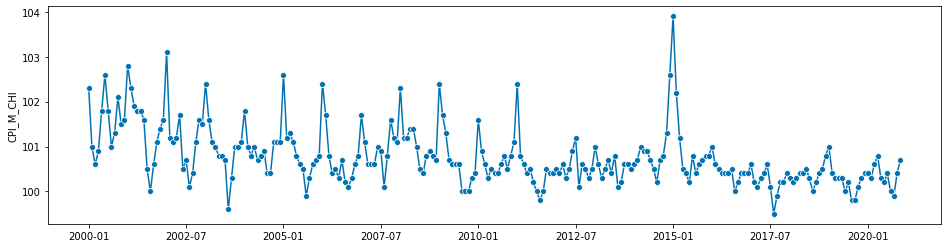

In [17]:
y = data['CPI_M_CHI'].loc['2000-01':'2020-11']
X = data[['IM_T_M', 'IM_NON-CIS_M']].loc['2000-01':'2020-11']
plot_series(y);

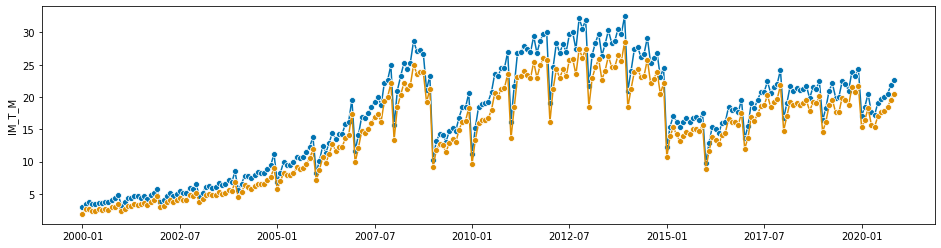

In [18]:
plot_series(X['IM_T_M'], X['IM_NON-CIS_M']);

(215,) (36,)


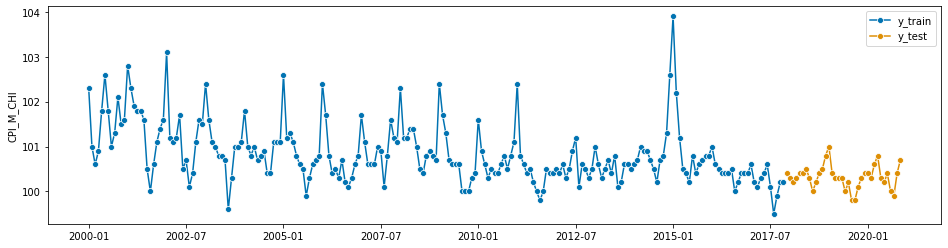

In [19]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
X_train, X_test = temporal_train_test_split(X, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape, y_test.shape)

In [20]:
# Forecasting horizon 
# Up to 36 steps ahead
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
             '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11',
             '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05',
             '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11',
             '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05',
             '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11'],
            dtype='period[M]', name='Period', freq='M', is_relative=False)

0.0022152235886192333

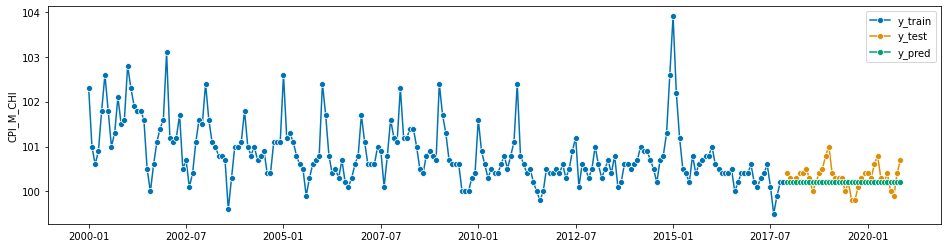

In [21]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

0.002243993236119042

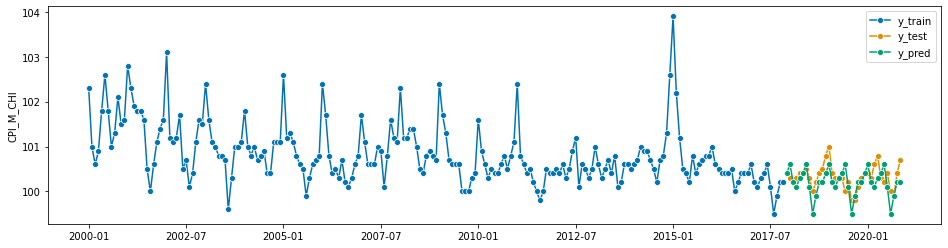

In [22]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

0.0038512536440666193

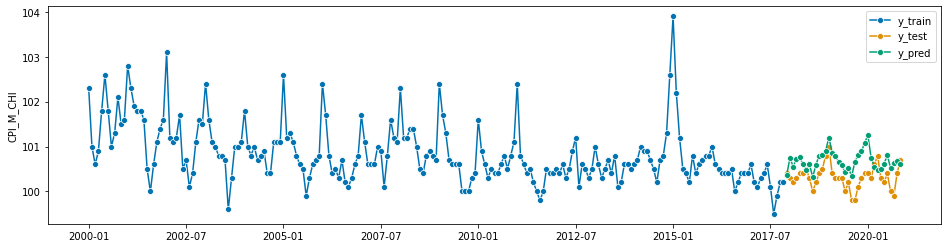

In [23]:
regressor = LinearRegression()
forecaster = ReducedForecaster(
    regressor=regressor, scitype='regressor', window_length=32, strategy="direct", step_length=1
)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.0032706475287739662

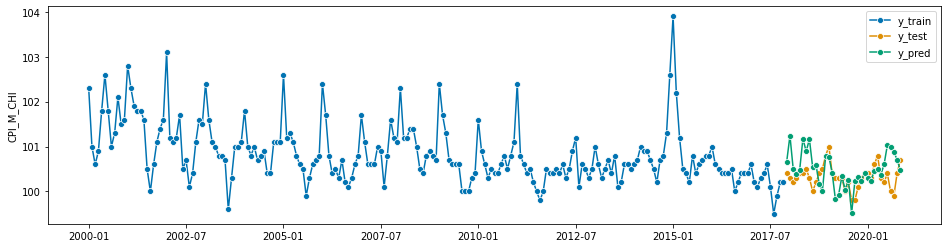

In [24]:
# With exogenous data
regressor = LinearRegression()
forecaster = MyDirectReducerForecaster(
    estimator=regressor, window_length=32, strategy="direct" # AR(32)
)
forecaster.fit(y_train, X_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.0034126357829976873

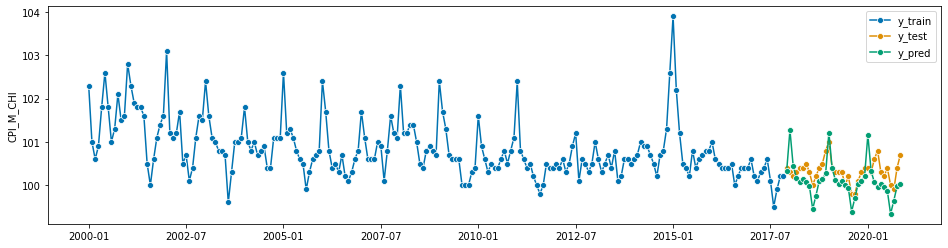

In [25]:
forecaster = ExponentialSmoothing(trend='add', seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.0019408076674417897

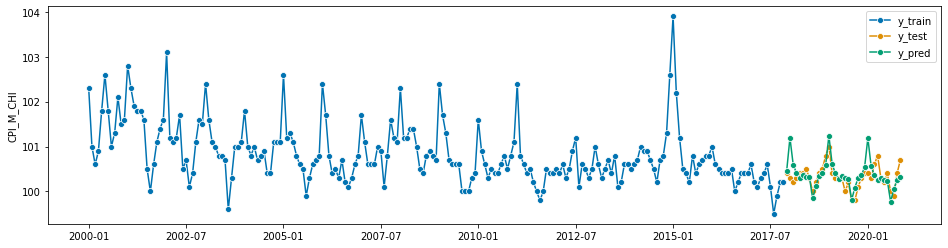

In [26]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [27]:
# regressor = KNeighborsRegressor(n_neighbors=1)
regressor = LinearRegression()
forecaster = MyDirectReducerForecaster(
    estimator=regressor, window_length=1, strategy="direct" # AR(1)
)
cv = SlidingWindowSplitter( 
    step_length=1, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], window_length=24
)
# Evaluate model using y and exogenous data X
df = evaluate(forecaster=forecaster, y=y['2000-09':'2020-10'], X=None, cv=cv, strategy="refit", return_data=True)
print(df['test_RMSE'].mean())
df.iloc[:, :5]


0.5751129637467459


,cutoff,fit_time,len_train_window,pred_time,test_RMSE
0,2002-08,0.009335,24,0.004724,0.395617
1,2002-09,0.010956,24,0.005301,0.514077
2,2002-10,0.010150,24,0.003237,0.616360
3,2002-11,0.005283,24,0.002879,0.646676
4,2002-12,0.005493,24,0.002878,0.637145
...,...,...,...,...,...
202,2019-06,0.007207,24,0.003397,0.241242
203,2019-07,0.007007,24,0.003437,0.243299
204,2019-08,0.007367,24,0.003739,0.268057
205,2019-09,0.007684,24,0.003591,0.418490


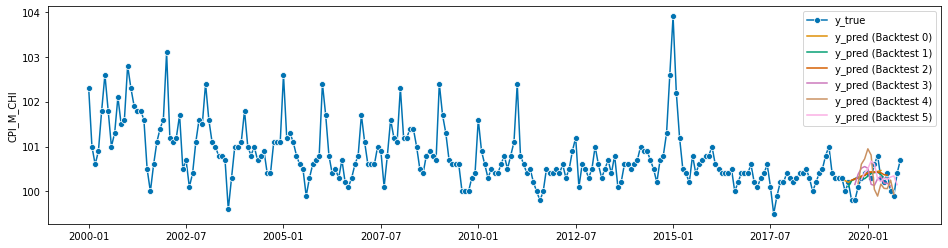

In [28]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[-6],
    df["y_pred"].iloc[-5],
    df["y_pred"].iloc[-4],
    df["y_pred"].iloc[-3],
    df["y_pred"].iloc[-2],
    df["y_pred"].iloc[-1],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

# Feature extraction

In [29]:
#@title Download articles
!wget 'https://docs.google.com/uc?export=download&id=1-X1VJ4ibI7a-_ZX43djcssx2COc9o2wa' -O rbc.xlsx &> /dev/null
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1--SgWBGIBYn3KUMwr4CjVEAlvmErW3jh' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1--SgWBGIBYn3KUMwr4CjVEAlvmErW3jh" -O lenta.xlsx && rm -rf /tmp/cookies.txt &> /dev/null

--2021-03-20 13:16:41--  https://docs.google.com/uc?export=download&confirm=LCp6&id=1--SgWBGIBYn3KUMwr4CjVEAlvmErW3jh
Resolving docs.google.com (docs.google.com)... 142.250.103.139, 142.250.103.102, 142.250.103.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.103.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-2o-docs.googleusercontent.com/docs/securesc/64tub4hqerf8a1vdotlhlf0g49ekrsto/isa75oskkncjfgs18gi98h3oljvuvqjq/1616246175000/09666267334096540847/16802449828036196356Z/1--SgWBGIBYn3KUMwr4CjVEAlvmErW3jh?e=download [following]
--2021-03-20 13:16:41--  https://doc-0o-2o-docs.googleusercontent.com/docs/securesc/64tub4hqerf8a1vdotlhlf0g49ekrsto/isa75oskkncjfgs18gi98h3oljvuvqjq/1616246175000/09666267334096540847/16802449828036196356Z/1--SgWBGIBYn3KUMwr4CjVEAlvmErW3jh?e=download
Resolving doc-0o-2o-docs.googleusercontent.com (doc-0o-2o-docs.googleusercontent.com)... 172.253.119.132, 2607:f8b0:4001:c23::84
Conne

In [30]:
#@title Load data
def load_articles():
    ###### RBC #####
    # Load and sort by date
    rbc = pd.read_excel('rbc.xlsx', index_col=0).sort_values('publish_date_t')

    # Proper indexing
    idx = rbc.apply(lambda x: datetime.fromtimestamp(x['publish_date_t']).strftime('%Y-%m'), axis=1)
    idx = pd.PeriodIndex(idx.tolist(), freq='M', name='Period')
    rbc.index = idx

    # Drop unnecessary columns
    rbc.drop(columns = ['Unnamed: 0.1',
                        'id', 'fronturl',
                        'publish_date_t',
                        'publish_date', 
                        'photo', 'project',
                        'category', 'opinion_authors',
                        'authors'], inplace=True)
    
    rbc = rbc.apply(lambda x: x.astype('str'))
    
    ###### lenta #####
    # Load and sort by date
    lenta = pd.read_excel('lenta.xlsx', index_col=0).sort_values('pubdate')

    # Proper indexing
    idx = lenta.apply(lambda x: datetime.fromtimestamp(x['pubdate']).strftime('%Y-%m'), axis=1)
    idx = pd.PeriodIndex(idx.tolist(), freq='M', name='Period')
    lenta.index = idx

    # Drop unnecessary columns
    lenta.drop(columns = ['docid',
                          'image_url',
                          'lastmodtime',
                          'part', 'type',
                          'url', 'tags',
                          'bloc', 'domain',
                          'modified', 'pubdate',
                          'status'], inplace=True)
    
    lenta = lenta.apply(lambda x: x.astype('str'))

    return rbc, lenta

rbc, lenta = load_articles()

In [31]:
rbc.head()

,title,anons,overview,text
Period,,,,
2000-09,В.Путин торопит разработчиков военной реформы,... заявление он сделал перед совещанием чле...,"Президент России Владимир Путин считает, что к...","Президент России Владимир Путин считает, что к..."
2000-10,"Вяхирев хочет продать ""Медиа-Мост"" европейцам","... при прекращении дефолта, что ""Медиа-Мост...",Сопровождающий президента России Владимира Пут...,"По словам Р.Вяхирева, это будет открытый тенде..."
2000-10,Седьмая годовщина пролетарской революции,... и манифестаций. Совместными колоннами пр...,Сегодня Москва отмечает 7-ую годовщину трагиче...,В связи с этим власти дали разрешение на прове...
2000-10,Арафат и Барак будут договариваться,... всеобъемлющего урегулирования по всем гл...,Глава Палестинской автономии Ясир Арафат напра...,Перед отъездом Я.Арафат провел совещание с пре...
2000-10,Милиция хочет упорядочить обмен валюты,... предложения по изменению норм осуществле...,МВД РФ совместно с Банком России готовит предл...,Сейчас на территории нашей страны действует ок...


In [32]:
lenta.head()

,rightcol,title,text,snippet
Period,,,,
2000-01,В минувшее воскресенье исполняющий обязанности...,"Дорожает алкоголь, табак, бензин, автомобили и...",В минувшее воскресенье исполняющий обязанности...,"В минувшее воскресенье исполняющий ... ""Об акц..."
2000-01,Центробанк хочет усилить госкотроль за валютны...,Виктор Геращенко предлагет усилить госконтроль...,Усилить госконтроль на валютном рынке предложи...,Усилить госконтроль на валютном рынке ... Цент...
2000-01,Началась промышленная печать монет и купюр ЕВРО,Европа печатает и чеканит новые деньги,В Европе началась промышленная печать купюр и ...,В Европе началась промышленная печать купюр и ...
2000-01,Цена российской нефти снизилась,Российская нефть дешевеет,Цена российской нефти Urals с доставкой в порт...,Цена российской нефти Urals с доставкой ... со...
2000-01,Доступ нефтедобывающих компаний к экспортной т...,Нефтедобывающим компаниям-должникам ограничат ...,В 2000 году доступ нефтедобывающих компаний к ...,В 2000 году доступ нефтедобывающих ... недоимк...


## Preprocessing for tf-idf

In [33]:
# Скачаем MyStem
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz &> /dev/null
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz &> /dev/null
!cp mystem /bin &> /dev/null

from pymystem3 import Mystem
m = Mystem()

In [34]:
# Стоп слова
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
# Пунктуации
from string import punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
#@title Preprocess function for text
def preprocess(w):
    if not isinstance(w, str) or w is None:
        return ''
        # return []
    
    # w = unicode_to_ascii(w.lower().strip())
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except r"[^a-zA-Zа-яА-Я?.!,¿]+": (a-z, A-Z, а-я, А-Я, ".", "?", "!", ",")
    # w = re.sub(r"[^a-zA-Zа-яА-Я?.!]+", " ", w)
    w = re.sub(r"[0-9+]+", "num_", w) # add num_ token  
    w = re.sub(r"[^a-zA-Zа-яА-Я_]+", " ", w)

    # Лемматизируем
    w = ''.join(m.lemmatize(w)).strip()
    # w = m.lemmatize(w)
    
    # Save as sentences
    # w = re.split(r' ! | \. | \? ', w)
    # w = [[j for j in i.split() if j not in russian_stopwords\
    #           and j != " " and j != (' \n' or '\n')\
    #           and j not in punctuation] for i in w]
    
    # w = [word for word in w if word not in russian_stopwords\
    #           and word != " " and word != (' \n' or '\n')]
    
    # w = [word for word in w if word not in russian_stopwords\
    #           and word != " " and word != (' \n' or '\n')\
    #           and word not in punctuation]

    # w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    # w = '<start> ' + w + ' <end>'
    return w

In [36]:
#@title TF-IDF Transformer
class TfidfTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        # self._feature_names = feature_names
        self.transformer = clone(transformer)
        
    def fit(self, X, y = None):
        # X -- nested series of texts
        X = pd.concat(X.tolist())
        self.transformer.fit(X)
        return self 
    
    def transform(self, X, y = None):
        # X -- nested series of texts

        # Save unique indecies
        unq_idx = X.index

        # From nested array to series
        X = pd.concat(X.tolist())

        # Save all indecies
        idx = X.index

        # Tf-Idf transform
        X = self.transformer.transform(X)

        # Add time indecies
        X = pd.DataFrame(
            X.toarray(), index = idx
        )

        # Return monthly averages
        res = []
        for i in unq_idx:
            res.append(X[X.index == i].mean(axis=0))
        return pd.DataFrame(
            res, index = unq_idx
        )

In [37]:
#@title TF-IDF Model
class TfidfModel(BaseEstimator, RegressorMixin):
    def __init__(self):

        vectorizer = TfidfVectorizer(
            max_features = 5000, min_df=0.1, max_df = 0.9
        )
        self.transformer = TfidfTransformer(
            vectorizer
        )
        self.regressor = MyDirectReducerForecaster(
            estimator=LinearRegression(), strategy="direct",
             window_length=1, step_length=1
        )
        
    def fit(self, y, X = None, fh = None):
        # X -- nested series of texts
        
        self.fh = fh

        self.cutoff = y.index[-1]

        X = self.transformer.fit_transform(X)
        print('Длина словаря:', len(self.transformer.transformer.vocabulary_))
        self.regressor.fit(y, X, fh)
        return self
    
    def predict(self, fh, X = None):
        
        return self.regressor.predict(self.fh)

In [38]:
tf_features = rbc.progress_apply(lambda x: preprocess(x['title']) + ' ' + preprocess(x['text']), axis = 1)
tf_features.head()

Period
2000-09    в путин торопить разработчик военный реформа п...
2000-10    вяхирев хотеть продавать медиа мост европеец п...
2000-10    седьмой годовщина пролетарский революция в свя...
2000-10    арафат и барак быть договариваться перед отъез...
2000-10    милиция хотеть упорядочивать обмен валюта сейч...
Freq: M, dtype: object

In [39]:
# Monthly features
def make_monthly(data):
    data_M = []
    for i in np.unique(data.index):
        data_M.append(data[data.index == i])
    data_M = pd.Series(
        data_M, index = np.unique(data.index)
    )
    return data_M

tf_features_M = make_monthly(tf_features)

In [40]:
forecaster = TfidfModel()
cv = SlidingWindowSplitter( 
    step_length=1, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], window_length=24
)
# Evaluate model using y and exogenous data X
df = evaluate(forecaster=forecaster, y=y['2000-09':'2020-10'],
              X=tf_features_M,
              cv=cv, strategy="refit", return_data=True) 
print(df['test_RMSE'].mean())
df.iloc[:, :6]

Длина словаря: 222
Длина словаря: 223
Длина словаря: 229
Длина словаря: 232
Длина словаря: 238
Длина словаря: 240
Длина словаря: 235
Длина словаря: 236
Длина словаря: 238
Длина словаря: 233
Длина словаря: 237
Длина словаря: 238
Длина словаря: 237
Длина словаря: 237
Длина словаря: 249
Длина словаря: 252
Длина словаря: 258
Длина словаря: 262
Длина словаря: 260
Длина словаря: 265
Длина словаря: 270
Длина словаря: 274
Длина словаря: 293
Длина словаря: 306
Длина словаря: 313
Длина словаря: 329
Длина словаря: 343
Длина словаря: 341
Длина словаря: 363
Длина словаря: 368
Длина словаря: 370
Длина словаря: 373
Длина словаря: 376
Длина словаря: 390
Длина словаря: 391
Длина словаря: 396
Длина словаря: 394
Длина словаря: 397
Длина словаря: 392
Длина словаря: 395
Длина словаря: 402
Длина словаря: 402
Длина словаря: 407
Длина словаря: 414
Длина словаря: 411
Длина словаря: 418
Длина словаря: 416
Длина словаря: 411
Длина словаря: 402
Длина словаря: 406
Длина словаря: 395
Длина словаря: 393
Длина словар

KeyboardInterrupt: ignored

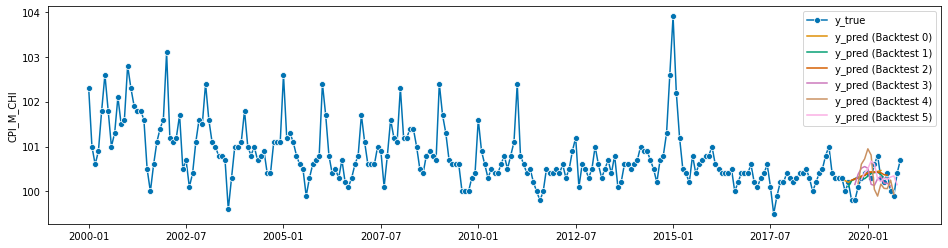

In [41]:
# visualization of a forecasting with news
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[-6],
    df["y_pred"].iloc[-5],
    df["y_pred"].iloc[-4],
    df["y_pred"].iloc[-3],
    df["y_pred"].iloc[-2],
    df["y_pred"].iloc[-1],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

# Dostoevsky. Rusentiment dataset
http://text-machine.cs.uml.edu/projects/rusentiment/

https://github.com/bureaucratic-labs/dostoevsky

In [42]:
!pip install dostoevsky

!wget -P /usr/local/lib/python3.7/dist-packages/dostoevsky/data/models/ https://storage.b-labs.pro/models/fasttext-social-network-model.bin 

     |████████████████████████████████| 71kB 2.3MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3098117 sha256=1b5df7a451b999784c6637d333df4d85150e2bd0a7d9b10ce1ce645586594f99
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
--2021-03-20 13:29:12--  https://storage.b-labs.pro/models/fasttext-social-network-model.bin
Resolving storage.b-labs.pro (storage.b-labs.pro)... 104.21.14.222, 172.67.160.159, 2606:4700:3035::6815:ede, ...
Connecting to storage.b-labs.pro (storage.b-labs.pro)|104.21.14.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84051390 (80M) [application/x-sega-cd-rom]
Saving to: ‘/usr/local/lib/python3.7/dist-packages/dostoevsky/data/models/fasttext-social-network-model.bin’

fasttext-social-net 100%[===================>]  80.16M  10.3MB/s    in 9.1s    

2021-03-20 13:29:22 (8.81 MB/s) - ‘/usr/local/lib/python3.7/d

In [43]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

tokenizer = RegexTokenizer()

model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [44]:
def apply_rusentiment(model, texts):
    if texts.ndim == 1:
        rusentiment = texts.progress_apply(lambda x: model.predict(x, k=5))
        print(rusentiment)
        rusentiment = pd.DataFrame(rusentiment.tolist(), index=rusentiment.index, columns=['scores'])
        rusentiment = pd.DataFrame(rusentiment).progress_apply(lambda x: pd.Series(x), axis=1)
    else:
        rusentiment = texts.progress_apply(lambda x: model.predict([*x[['title', 'text']]], k=5), axis=1)
        rusentiment = pd.DataFrame(rusentiment.tolist(), index=rusentiment.index, columns=['title', 'text'])
        rusentiment = pd.concat([
                                pd.DataFrame(rusentiment).progress_apply(lambda x: pd.Series(x['title']), axis=1),
                                pd.DataFrame(rusentiment).progress_apply(lambda x: pd.Series(x['text']), axis=1)
        ], axis=1)
        rusentiment.columns = [i + '_title' for i in rusentiment.columns[:5]] + [i + '_text' for i in rusentiment.columns[5:]]
    return rusentiment

In [45]:
rusentiment = apply_rusentiment(model, rbc)
rusentiment.head()

,negative_title,neutral_title,positive_title,skip_title,speech_title,negative_text,neutral_text,positive_text,skip_text,speech_text
Period,,,,,,,,,,
2000-09,0.069552,0.724880,0.092698,0.030225,0.001937,0.228166,0.531219,0.073706,0.106701,0.033096
2000-10,0.164526,0.822199,0.022296,0.095359,0.000720,0.112805,0.787941,0.050341,0.112805,0.007826
2000-10,0.014967,0.835494,0.023699,0.056662,0.001294,0.160276,0.679189,0.069552,0.085109,0.014514
2000-10,0.028446,0.100889,0.100889,0.399822,0.002407,0.196836,0.577505,0.092698,0.115971,0.011697
2000-10,0.281416,0.787941,0.039649,0.039649,0.000010,0.212079,0.737168,0.056662,0.071601,0.013233


In [46]:
rusentiment_M = make_monthly(rusentiment)
rusentiment_M = rusentiment_M.map(lambda x: x.mean(axis=0))
rusentiment_M = pd.DataFrame(list(map(list, rusentiment_M.tolist())),
                    index=rusentiment_M.index,
                    columns=rusentiment_M[0].index
)
rusentiment_M.head()

,negative_title,neutral_title,positive_title,skip_title,speech_title,negative_text,neutral_text,positive_text,skip_text,speech_text
2000-09,0.069552,0.724880,0.092698,0.030225,0.001937,0.228166,0.531219,0.073706,0.106701,0.033096
2000-10,0.157377,0.667885,0.080716,0.104764,0.001236,0.200945,0.692322,0.068691,0.078035,0.014032
2000-11,0.109534,0.737279,0.033369,0.119087,0.000844,0.181092,0.695479,0.067920,0.084794,0.016403
2000-12,0.180735,0.533161,0.038706,0.156745,0.036932,0.189031,0.650433,0.075667,0.080079,0.018709
2001-01,0.123767,0.624890,0.056033,0.132854,0.001408,0.210041,0.689194,0.068414,0.075361,0.018947


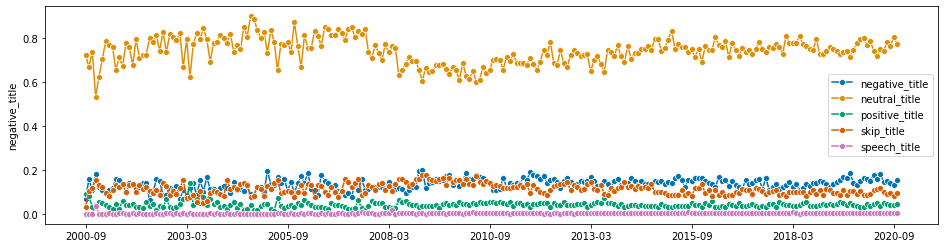

In [47]:
plot_series(rusentiment_M['negative_title'],
            rusentiment_M['neutral_title'],
            rusentiment_M['positive_title'],
            rusentiment_M['skip_title'],
            rusentiment_M['speech_title'],
            labels=["negative_title",
                    'neutral_title', 
                    'positive_title', 
                    'skip_title',
                    'speech_title'])
plt.show()

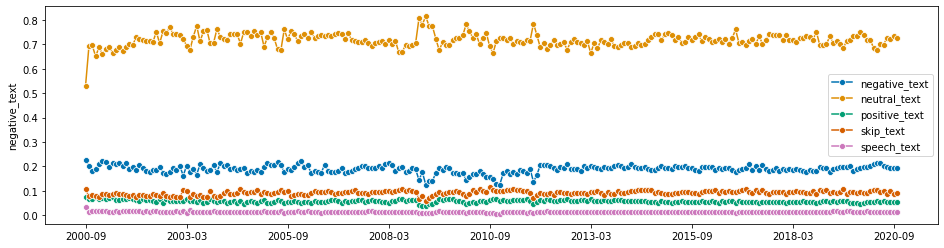

In [48]:
plot_series(rusentiment_M['negative_text'],
            rusentiment_M['neutral_text'],
            rusentiment_M['positive_text'],
            rusentiment_M['skip_text'],
            rusentiment_M['speech_text'],
            labels=["negative_text",
                    'neutral_text', 
                    'positive_text', 
                    'skip_text',
                    'speech_text'])
plt.show()

In [49]:
rusentiment_M = rusentiment_M[['positive_title', 'negative_title', 'positive_text', 'negative_text']]
rusentiment_M['title'] = rusentiment_M['positive_title'] - rusentiment_M['negative_title']
rusentiment_M['text'] = rusentiment_M['positive_text'] - rusentiment_M['negative_text']
alpha = 0.5
rusentiment_M['composite'] = alpha * rusentiment_M['title'] + (1 - alpha) * rusentiment_M['text']
rusentiment_M = rusentiment_M[['title', 'text', 'composite']]
rusentiment_M

,title,text,composite
2000-09,0.023146,-0.154460,-0.065657
2000-10,-0.076660,-0.132254,-0.104457
2000-11,-0.076166,-0.113172,-0.094669
2000-12,-0.142029,-0.113364,-0.127696
2001-01,-0.067734,-0.141628,-0.104681
...,...,...,...
2020-06,-0.096005,-0.142281,-0.119143
2020-07,-0.104397,-0.143147,-0.123772
2020-08,-0.098947,-0.138705,-0.118826
2020-09,-0.094346,-0.139130,-0.116738


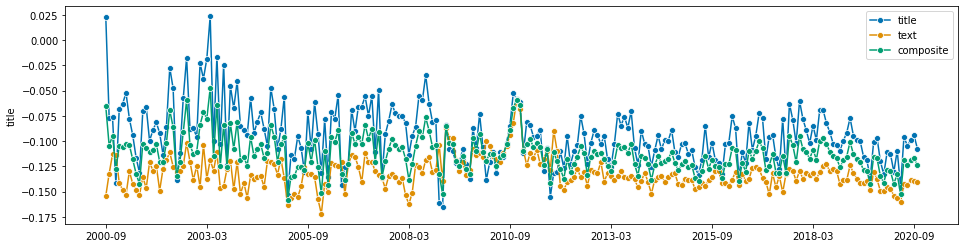

In [50]:
plot_series(rusentiment_M['title'],
            rusentiment_M['text'],
            rusentiment_M['composite'],
            labels=["title",'text', 'composite'])
plt.show()

In [64]:
regressor = LinearRegression()
forecaster = MyDirectReducerForecaster(
    estimator=regressor, window_length=1, strategy="direct" # AR(1)
)
cv = SlidingWindowSplitter( 
    step_length=1, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], window_length=24
)
# Evaluate model using y and exogenous data X
df = evaluate(forecaster=forecaster, y=data['PMI_Services_Russia'].loc['2012-07':'2020-09'],
              X=rusentiment_M['composite'].shift(-1).loc['2012-07':'2020-09'], cv=cv, strategy="refit", return_data=True)
print(df['test_RMSE'].mean())
df.iloc[:, :6]


5.169966208569872


,cutoff,fit_time,len_train_window,pred_time,test_RMSE,test_sMAPE
0,2014-06,0.162615,24,0.003527,9.887565,0.167570
1,2014-07,0.020085,24,0.003567,6.076211,0.102493
2,2014-08,0.020267,24,0.003545,5.562408,0.095035
3,2014-09,0.019817,24,0.003452,5.014185,0.084846
4,2014-10,0.019872,24,0.003520,5.158207,0.088421
...,...,...,...,...,...,...
59,2019-05,0.021196,24,0.003656,13.307353,0.172056
60,2019-06,0.021799,24,0.003892,13.876554,0.209866
61,2019-07,0.020623,24,0.003676,13.414519,0.200226
62,2019-08,0.021470,24,0.003567,14.135113,0.199649


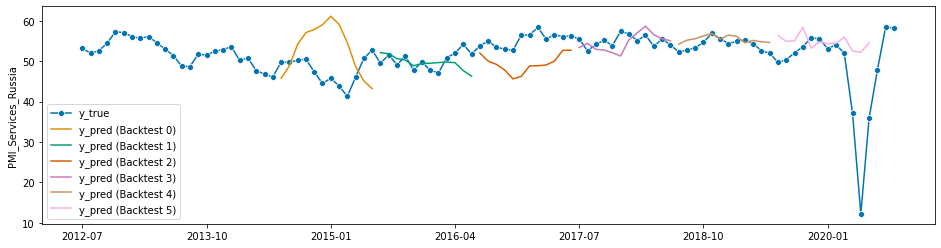

In [52]:
# visualization of a forecasting with news
fig, ax = plot_series(
    data['PMI_Services_Russia'].loc['2012-07':'2020-09'],
    df["y_pred"].iloc[-6],
    df["y_pred"].iloc[-5],
    df["y_pred"].iloc[-4],
    df["y_pred"].iloc[-3],
    df["y_pred"].iloc[-2],
    df["y_pred"].iloc[-1],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

In [65]:
regressor = LinearRegression()
forecaster = MyDirectReducerForecaster(
    estimator=regressor, window_length=1, strategy="direct" # AR(1)
)
cv = SlidingWindowSplitter( 
    step_length=1, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], window_length=24
)
# Evaluate model using y and exogenous data X
df = evaluate(forecaster=forecaster, y=data['PMI_Services_Russia'].loc['2012-07':'2020-09'],
              X=None, cv=cv, strategy="refit", return_data=True)
print(df['test_RMSE'].mean())
df.iloc[:, :6]


4.988743504736276


,cutoff,fit_time,len_train_window,pred_time,test_RMSE,test_sMAPE
0,2014-06,0.023849,24,0.008724,9.400742,0.159418
1,2014-07,0.007842,24,0.004088,6.441009,0.107594
2,2014-08,0.007975,24,0.003951,5.849232,0.099046
3,2014-09,0.007693,24,0.003885,5.424808,0.090052
4,2014-10,0.007426,24,0.003811,5.186820,0.087204
...,...,...,...,...,...,...
59,2019-05,0.005404,24,0.002911,13.071806,0.168253
60,2019-06,0.005090,24,0.002986,13.628125,0.198214
61,2019-07,0.005177,24,0.002948,13.404347,0.193908
62,2019-08,0.005094,24,0.002891,14.106026,0.202126


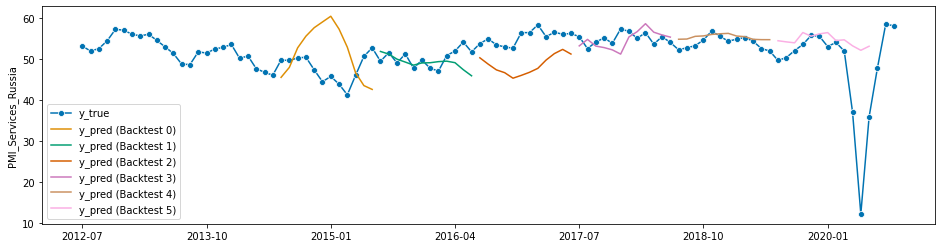

In [54]:
# visualization of a forecasting with news
fig, ax = plot_series(
    data['PMI_Services_Russia'].loc['2012-07':'2020-09'],
    df["y_pred"].iloc[-6],
    df["y_pred"].iloc[-5],
    df["y_pred"].iloc[-4],
    df["y_pred"].iloc[-3],
    df["y_pred"].iloc[-2],
    df["y_pred"].iloc[-1],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

# Тональный словарь русского языка

https://github.com/dkulagin/kartaslov/tree/master/dataset/emo_dict

In [55]:
url = "https://raw.githubusercontent.com/dkulagin/kartaslov/master/dataset/emo_dict/emo_dict.csv"
senti = pd.read_csv(url, sep=';')
senti.head()

,term,tag,value,pstv,neut,ngtv,dunno,distortion
0,аббат,NEUT,0.3667,0.2574,0.3762,0.0693,0.2970,0.0880
1,аббревиатура,NEUT,0.0000,0.1600,0.7200,0.0000,0.1200,0.0000
2,абзац,NEUT,0.0000,0.1481,0.7037,0.0000,0.1481,0.0000
3,абонемент,NEUT,0.1757,0.2381,0.5810,0.0476,0.1333,0.0571
4,абонентный,NEUT,0.0000,0.0000,0.7200,0.0000,0.2800,0.0000


In [56]:
# Negative words
terms = senti[senti.tag == 'NGTV'][['term','value']]
negative_dict = dict(zip(terms.term.values, terms.value.values))

# Positive words
terms = senti[senti.tag == 'PSTV'][['term','value']]
positive_dict = dict(zip(terms.term.values, terms.value.values))

def get_scores(w, ind_dict):
    scores = [ind_dict.get(item, 0) for item in w.split()]
    return np.mean(scores)

def make_dict_ind(texts, negative_dict, positive_dict):
    neg_ind = texts.progress_apply(lambda x: get_scores(x, negative_dict))

    pos_ind = texts.progress_apply(lambda x: get_scores(x, positive_dict))

    dict_ind = pd.concat([pos_ind, neg_ind], axis=1)
    dict_ind.columns = ['pos_ind', 'neg_ind']

    dict_ind_M = make_monthly(dict_ind)

    dict_ind_M = pd.DataFrame(dict_ind_M.map(lambda x: x.mean(axis=0).tolist()).tolist(),
                              index=dict_ind_M.index, columns = ['pos_ind', 'neg_ind'])
    
    dict_ind_M['neg_ind'] = - dict_ind_M['neg_ind']

    dict_ind_M['composite_ind'] = dict_ind_M['pos_ind'] - dict_ind_M['neg_ind']

    return dict_ind_M

In [57]:
dict_ind = make_dict_ind(tf_features, negative_dict, positive_dict)
dict_ind.head()

,pos_ind,neg_ind,composite_ind
2000-09,0.057303,0.033254,0.024049
2000-10,0.060175,0.025778,0.034397
2000-11,0.047795,0.020962,0.026833
2000-12,0.050259,0.024633,0.025626
2001-01,0.052995,0.031639,0.021356


In [58]:
plot_series(dict_ind['composite'], dict_ind['pos_ind'], dict_ind['neg_ind'],
            labels=['composite', 'pos_ind', 'neg_ind'])
plt.show()

KeyError: ignored

In [63]:
regressor = LinearRegression()
forecaster = MyDirectReducerForecaster(
    estimator=regressor, window_length=1, strategy="direct" # AR(1)
)
cv = SlidingWindowSplitter( 
    step_length=1, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], window_length=24
)
# Evaluate model using y and exogenous data X
df = evaluate(forecaster=forecaster, y=data['PMI_Services_Russia'].loc['2012-07':'2020-09'],
              X=dict_ind['neg_ind'].shift(-2).loc['2012-07':'2020-09'],
              cv=cv, strategy="refit", return_data=True)
print(df['test_RMSE'].mean())
df.iloc[:, :6]


5.0178643971335015


,cutoff,fit_time,len_train_window,pred_time,test_RMSE,test_sMAPE
0,2014-06,0.028545,24,0.003763,9.314834,0.158875
1,2014-07,0.027699,24,0.005700,6.208536,0.102647
2,2014-08,0.019926,24,0.003634,5.914373,0.100276
3,2014-09,0.020903,24,0.003502,5.694175,0.095285
4,2014-10,0.019952,24,0.003534,5.125509,0.086274
...,...,...,...,...,...,...
59,2019-05,0.028438,24,0.004134,13.678620,0.179215
60,2019-06,0.021909,24,0.003824,13.617658,0.197733
61,2019-07,0.017071,24,0.003242,13.388398,0.194194
62,2019-08,0.018759,24,0.005166,14.436231,0.207360


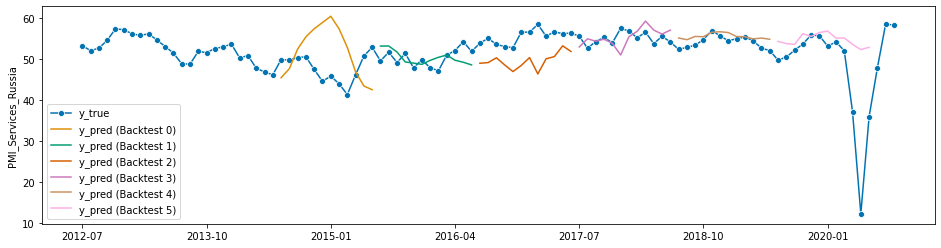

In [60]:
# visualization of a forecasting with news
fig, ax = plot_series(
    data['PMI_Services_Russia'].loc['2012-07':'2020-09'],
    df["y_pred"].iloc[-6],
    df["y_pred"].iloc[-5],
    df["y_pred"].iloc[-4],
    df["y_pred"].iloc[-3],
    df["y_pred"].iloc[-2],
    df["y_pred"].iloc[-1],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

In [61]:
data.corr()

,CPI_M_CHI,IM_T_M,IM_NON-CIS_M,INVFC_M,IP2_EA_M,IP2_EA_M_SA,RTRD_M_DIRI,RTRD_M_DIRI_SA,RTRD_M,UNEMPL_M_SH,WAG_M,WAG_M_SA,WAG_C_M,PMI_Services_Russia,PMI_Manufacturing_Russia
CPI_M_CHI,1.000000,-0.365860,-0.367622,-0.292935,-0.215205,-0.423669,-0.373926,-0.381200,-0.303054,0.254339,-0.348313,-0.346883,-0.375744,-0.281704,-0.017528
IM_T_M,-0.365860,1.000000,0.998975,0.844023,0.371440,0.175237,0.936617,0.925877,0.789707,-0.780382,0.884225,0.877941,0.769043,0.141887,0.164884
IM_NON-CIS_M,-0.367622,0.998975,1.000000,0.850368,0.399210,0.195309,0.946574,0.936127,0.808577,-0.789284,0.897739,0.892147,0.787729,0.140452,0.159660
INVFC_M,-0.292935,0.844023,0.850368,1.000000,0.916297,-0.069599,0.924851,0.847042,0.914128,-0.694902,0.905350,0.842599,0.908868,0.038496,0.283661
IP2_EA_M,-0.215205,0.371440,0.399210,0.916297,1.000000,0.683059,0.551721,-0.199937,0.926802,-0.313886,0.713870,0.559597,0.748717,0.296822,0.110042
IP2_EA_M_SA,-0.423669,0.175237,0.195309,-0.069599,0.683059,1.000000,-0.039121,-0.245524,0.698618,-0.450830,0.588323,0.853196,0.816110,0.210855,-0.054024
RTRD_M_DIRI,-0.373926,0.936617,0.946574,0.924851,0.551721,-0.039121,1.000000,0.975157,0.919759,-0.831261,0.967934,0.952271,0.891670,0.173641,0.184068
RTRD_M_DIRI_SA,-0.381200,0.925877,0.936127,0.847042,-0.199937,-0.245524,0.975157,1.000000,0.912668,-0.845664,0.959712,0.976542,0.896830,-0.080587,0.032911
RTRD_M,-0.303054,0.789707,0.808577,0.914128,0.926802,0.698618,0.919759,0.912668,1.000000,-0.831489,0.960419,0.961161,0.990794,0.141325,-0.093985
UNEMPL_M_SH,0.254339,-0.780382,-0.789284,-0.694902,-0.313886,-0.450830,-0.831261,-0.845664,-0.831489,1.000000,-0.851827,-0.865105,-0.794946,-0.307971,-0.225975


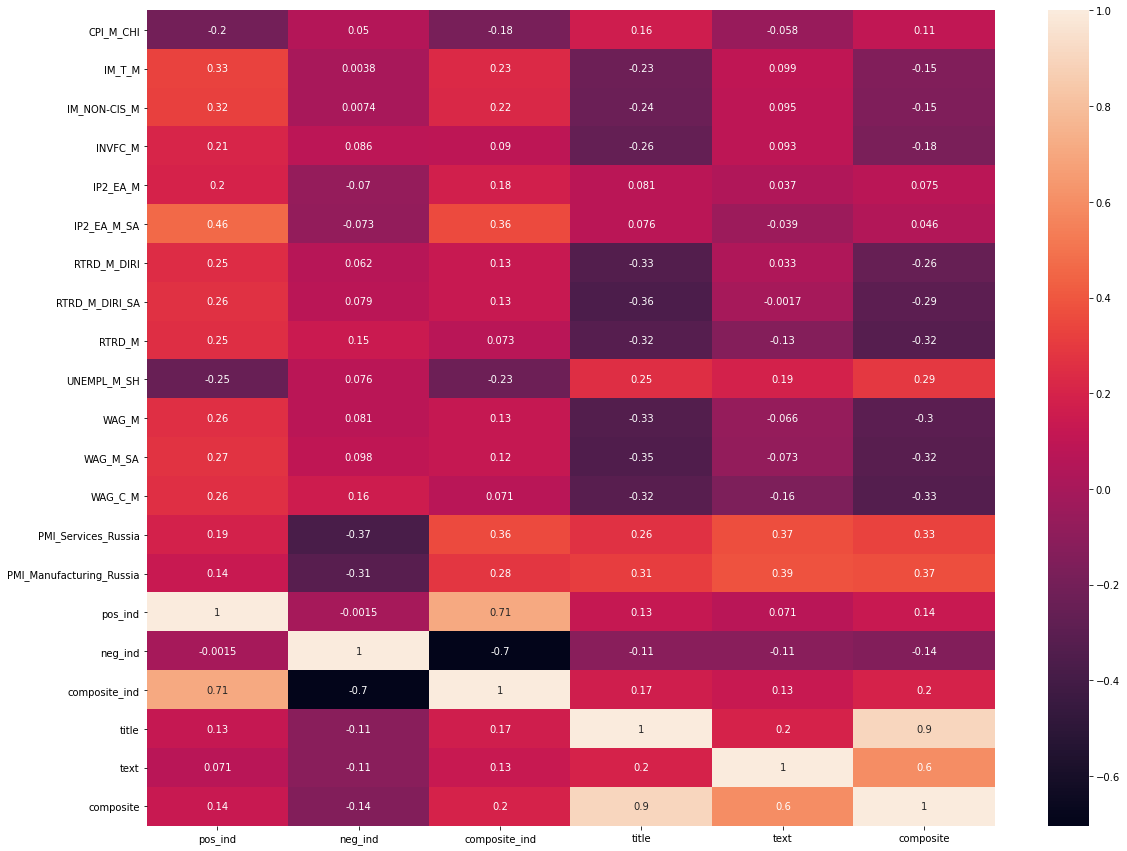

In [62]:
corrM = pd.concat([data, dict_ind, rusentiment_M], axis=1).corr()[['pos_ind', 'neg_ind', 'composite_ind', 'title', 'text', 'composite']]
f = plt.figure(figsize=(19, 15))
sns.heatmap(corrM, annot=True)
plt.show()